In [280]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [281]:
bike1_df = pd.read_csv("data/metro-trips-2025-q1.csv")
bike2_df = pd.read_csv("data/metro-trips-2025-q2.csv")
bike3_df = pd.read_csv("data/metro-trips-2025-q3.csv")

bike_df = pd.concat([bike1_df, bike2_df, bike3_df], ignore_index=True)

bike_keep_cols = [
    "trip_id",
    "duration",
    "start_time",
    "end_time",
    "bike_type"
]

bike_clean = bike_df[bike_keep_cols].copy()

bike_clean["start_time"] = pd.to_datetime(bike_clean["start_time"], errors="coerce")
bike_clean["end_time"] = pd.to_datetime(bike_clean["end_time"], errors="coerce")

bike_clean["date"] = bike_clean["start_time"].dt.date

bike_clean.head()

,trip_id,duration,start_time,end_time,bike_type,date
0,475609834,5,2025-01-01 00:12:00,2025-01-01 00:17:00,standard,2025-01-01
1,475609846,7,2025-01-01 00:12:00,2025-01-01 00:19:00,electric,2025-01-01
2,475609903,11,2025-01-01 00:13:00,2025-01-01 00:24:00,standard,2025-01-01
3,475609904,11,2025-01-01 00:13:00,2025-01-01 00:24:00,electric,2025-01-01
4,475610048,13,2025-01-01 00:27:00,2025-01-01 00:40:00,standard,2025-01-01


In [282]:
weather_df = pd.read_csv("data/visual-crossing-weather-data.csv")

weather_keep_cols = [
    "datetime",
    "tempmax",
    "tempmin",
    "temp",
    "humidity",
    "precip",
    "precipprob",
    "windspeed",
    "conditions"
]

weather_clean = weather_df[weather_keep_cols].copy()
weather_clean["date"] = pd.to_datetime(weather_clean["datetime"], errors="coerce")
weather_clean["date"] = weather_clean["date"].dt.date

weather_clean.head()

,datetime,tempmax,tempmin,temp,humidity,precip,precipprob,windspeed,conditions,date
0,2025-01-01,64.1,42.5,51.4,81.8,0.0,0,8.0,Partially cloudy,2025-01-01
1,2025-01-02,76.5,40.2,55.9,59.0,0.0,0,8.4,Clear,2025-01-02
2,2025-01-03,68.8,44.6,53.2,66.5,0.0,0,12.3,Clear,2025-01-03
3,2025-01-04,62.1,46.2,53.2,76.4,0.0,0,9.9,Partially cloudy,2025-01-04
4,2025-01-05,73.1,43.7,57.1,49.0,0.0,0,11.9,Clear,2025-01-05


In [283]:
merged_df = bike_clean.merge(weather_clean, on="date", how="left").drop(columns='datetime')

merged_df.head()

,trip_id,duration,start_time,end_time,bike_type,date,tempmax,tempmin,temp,humidity,precip,precipprob,windspeed,conditions
0,475609834,5,2025-01-01 00:12:00,2025-01-01 00:17:00,standard,2025-01-01,64.1,42.5,51.4,81.8,0.0,0,8.0,Partially cloudy
1,475609846,7,2025-01-01 00:12:00,2025-01-01 00:19:00,electric,2025-01-01,64.1,42.5,51.4,81.8,0.0,0,8.0,Partially cloudy
2,475609903,11,2025-01-01 00:13:00,2025-01-01 00:24:00,standard,2025-01-01,64.1,42.5,51.4,81.8,0.0,0,8.0,Partially cloudy
3,475609904,11,2025-01-01 00:13:00,2025-01-01 00:24:00,electric,2025-01-01,64.1,42.5,51.4,81.8,0.0,0,8.0,Partially cloudy
4,475610048,13,2025-01-01 00:27:00,2025-01-01 00:40:00,standard,2025-01-01,64.1,42.5,51.4,81.8,0.0,0,8.0,Partially cloudy


In [284]:
# 2025 average temperature

weather_df['temp'].mean()

63.02215568862276

In [285]:
# round temp to whole number

merged_df['temp_round'] = merged_df['temp'].round().astype(int)

# temperature with the most total bike-share trips

merged_df.groupby('temp_round')['trip_id'].count().sort_values(ascending=False).index[0]

68

In [286]:
# ^this is biased so we normalized -->

In [287]:
# total rides per temperature

temp_totals = merged_df.groupby('temp_round')['trip_id'].count()

# number of days each temperature occurred

temp_days = merged_df.groupby('temp_round')['date'].nunique()

# on a typical day at this temperature, how many total rides occur

avg_daily_trips_by_temp = temp_totals / temp_days

avg_daily_trips_by_temp.sort_values(ascending=False).index[0]


63

In [288]:
# on a typical day at this temperature, how many total minutes/hours of riding happen

temp_duration_totals = merged_df.groupby('temp_round')['duration'].sum()
temp_days = merged_df.groupby('temp_round')['date'].nunique()
avg_daily_duration_by_temp = temp_duration_totals / temp_days

avg_daily_duration_by_temp.sort_values(ascending=False).index[0]

63

In [289]:
# 2025 average windspeed

weather_df['windspeed'].mean()

11.539221556886226

In [290]:
# round windspeed to the nearest 0.5

merged_df['windspeed_round'] = (merged_df['windspeed'] * 2).round() / 2

In [291]:
# windspeed with the most total bike-share trips

merged_df.groupby('windspeed_round')['trip_id'].count().sort_values(ascending=False).index[0]

10.5

In [292]:
# ^this is biased so we normalized -->

In [293]:
# total rides per windspeed

windspeed_totals = merged_df.groupby('windspeed_round')['trip_id'].count()

# number of days each windspeed occurred

windspeed_days = merged_df.groupby('windspeed_round')['date'].nunique()

# on a typical day at this windspeed, how many total rides occur

avg_daily_trips_by_windspeed = windspeed_totals / windspeed_days

avg_daily_trips_by_windspeed.sort_values(ascending=False).index[0]

13.0

In [294]:
# percentage of days with precipitation

weather_df[weather_df['precip'] != 0].shape[0] / weather_df.shape[0]

0.12874251497005987

In [295]:
# bin days into rainy or dry

merged_df['precip_bin'] = merged_df['precip'].apply(lambda x: "Rain" if x > 0 else "No Rain")

# total rides on rainy vs. dry days

precip_totals = merged_df.groupby('precip_bin')['trip_id'].count()

# num days with or without rain

precip_days = merged_df.groupby('precip_bin')['date'].nunique()

# on a day with rain or without rain, how many total rides occur

avg_daily_trips_by_precip = precip_totals / precip_days

avg_daily_trips_by_precip


precip_bin
No Rain    1269.713693
Rain       1027.781250
dtype: float64

In [296]:
# on a day with rain or without rain, how many total minutes/hours of riding happen

precip_duration_totals = merged_df.groupby('precip_bin')['duration'].sum()
avg_daily_duration_by_precip = precip_duration_totals / precip_days

avg_daily_duration_by_precip

precip_bin
No Rain    41428.556017
Rain       28177.656250
dtype: float64

In [297]:
# round precip

merged_df['precip_round'] = merged_df['precip'].round(2)

# correlation matrix

daily_df = merged_df.groupby('date').agg({
    'trip_id': 'count',
    'temp_round': 'mean',
    'windspeed_round': 'mean',
    'precip_round': 'mean'
}).reset_index()

daily_df.corr(numeric_only=True)


,trip_id,temp_round,windspeed_round,precip_round
trip_id,1.000000,0.435281,-0.146369,-0.326237
temp_round,0.435281,1.000000,-0.196754,-0.224161
windspeed_round,-0.146369,-0.196754,1.000000,0.377313
precip_round,-0.326237,-0.224161,0.377313,1.000000


In [298]:
# ^this tells us that there a moderate positive correlation for temperature vs trip count exists
# meaning warmer days → more bike-share trips & cool days → fewer trips
# also tells us that a moderate negative correlation for precipitation vs trip count exists
# meaning any measurable rain pushes ridership down but effect not as strong as temperature

In [299]:
# weather condition with the most total bike-share trips

merged_df.groupby('conditions')['trip_id'].count().sort_values(ascending=False).index[0]

'Partially cloudy'

In [300]:
# ^this is biased so we normalized -->

In [301]:
# on a typical day with this weather condition, how many total rides occur

condition_totals = merged_df.groupby('conditions')['trip_id'].count()
condition_days = merged_df.groupby('conditions')['date'].nunique()
proportion = condition_totals / condition_days

proportion

conditions
Clear                     1221.532468
Overcast                  1332.200000
Partially cloudy          1288.322148
Rain                      1344.000000
Rain, Overcast             929.363636
Rain, Partially cloudy    1066.100000
dtype: float64

In [302]:
# on a typical day with this weather condition, how many total minutes/hours of riding happen

condition_duration_totals = merged_df.groupby('conditions')['duration'].sum()
condition_days = merged_df.groupby('conditions')['date'].nunique()
avg_daily_duration = condition_duration_totals / condition_days

avg_daily_duration

conditions
Clear                     39931.831169
Overcast                  39953.266667
Partially cloudy          42350.550336
Rain                      27887.000000
Rain, Overcast            25724.545455
Rain, Partially cloudy    29541.400000
dtype: float64

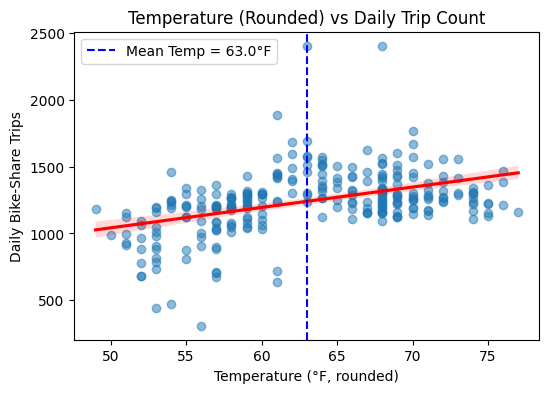

In [303]:
# temperature vs trips scatterplot with linear trend line,  direction & strength of the relationship, and mean temperature

mean_temp = weather_df['temp'].mean()

plt.figure(figsize=(6, 4))

# scatter + regression line

sns.regplot(
    data=daily_df,
    x='temp_round',
    y='trip_id',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

# vertical dashed line for average temperature

plt.axvline(
    x=mean_temp,
    color='blue',
    linestyle='--',
    linewidth=1.5,
    label=f"Mean Temp = {mean_temp:.1f}°F"
)

plt.title("Temperature (Rounded) vs Daily Trip Count")
plt.xlabel("Temperature (°F, rounded)")
plt.ylabel("Daily Bike-Share Trips")
plt.legend()
plt.show()

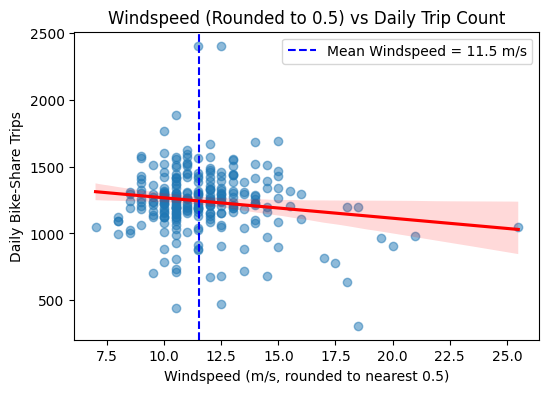

In [304]:
# windspeed vs trips scatterplot with linear trend line,  direction & strength of the relationship, and mean windspeed

mean_wind = weather_df['windspeed'].mean()

plt.figure(figsize=(6, 4))

# scatter + regression line

sns.regplot(
    data=daily_df,
    x='windspeed_round',
    y='trip_id',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

# vertical dashed line for average windspeed

plt.axvline(
    x=mean_wind,
    color='blue',
    linestyle='--',
    linewidth=1.5,
    label=f"Mean Windspeed = {mean_wind:.1f} m/s"
)

plt.title("Windspeed (Rounded to 0.5) vs Daily Trip Count")
plt.xlabel("Windspeed (m/s, rounded to nearest 0.5)")
plt.ylabel("Daily Bike-Share Trips")
plt.legend()
plt.show()


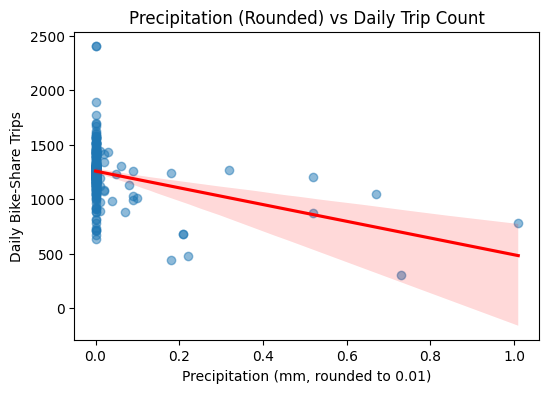

In [305]:
# precipitation vs trips scatterplot with linear trend line,  direction & strength of the relationship

plt.figure(figsize=(6, 4))
sns.regplot(
    data=daily_df,
    x='precip_round',
    y='trip_id',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)
plt.title("Precipitation (Rounded) vs Daily Trip Count")
plt.xlabel("Precipitation (mm, rounded to 0.01)")
plt.ylabel("Daily Bike-Share Trips")
plt.show()

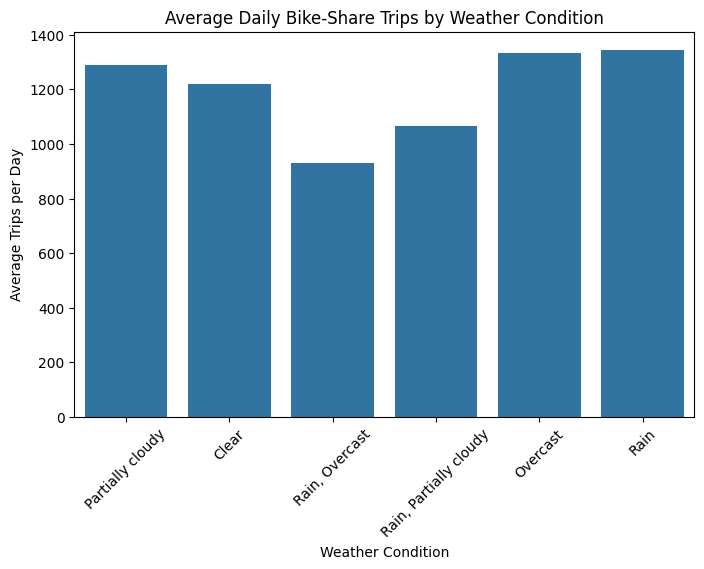

In [306]:
# average Trips per day per condition bar plot

daily_cond_df = merged_df.groupby(['date', 'conditions'])['trip_id'].count().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=daily_cond_df,
    x='conditions',
    y='trip_id',
    estimator='mean',
    errorbar=None
)

plt.title("Average Daily Bike-Share Trips by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Average Trips per Day")
plt.xticks(rotation=45)
plt.show()

In [307]:
# create a multiple linear regression model

conditions_dummies = pd.get_dummies(merged_df['conditions'], prefix='cond')

df_with_dummies = merged_df.join(conditions_dummies)

daily_df = df_with_dummies.groupby('date').agg(
    trip_id=('trip_id', 'count'),
    temp_round=('temp_round', 'mean'),
    windspeed_round=('windspeed_round', 'mean'),
    precip_round=('precip_round', 'mean'),
    **{col: (col, 'mean') for col in conditions_dummies.columns}
).reset_index()

dummy_cols = conditions_dummies.columns.tolist()

ref_col = dummy_cols[0]

X_cols = ['temp_round', 'windspeed_round', 'precip_round'] + [col for col in dummy_cols if col != ref_col]
X = daily_df[X_cols]

y = daily_df['trip_id']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                trip_id   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     12.51
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           3.36e-15
Time:                        14:35:21   Log-Likelihood:                -1837.2
No. Observations:                 273   AIC:                             3692.
Df Residuals:                     264   BIC:                             3725.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [308]:
# weather explains only about 27.5% of the variation in daily ridership.
# it makes sense that weather explains a small to moderate portion of variation in ridership because variation also comes from:
# weekdays vs weekends
# holidays
# seasonality
# tourism
# commute cycles
# special events
# random day-to-day factors


In [309]:
# temperature is indeed the strongest predictor
# coef = +12.52 meaning each 1°F increase --> ~12.5 more rides per day
# p < 0.0001 --> temperature is statistically significant
# the warmer the more ridership

In [310]:
# windspeed is not a meaningful predictor
# coef = +3.80 --> effect is very small and likely noise
# p = 0.538 --> not statistically significant

In [311]:
# precipitation has a strong negative effect
# coef = -400.99 meaning even light rain reduces ridership by ~401 trips per 1 mm of rain
# p = 0.011 --> precipitation is statistically significant
# the more rain the less bike-share usage


In [312]:
# overcast has a significant positive effect
# coef = +121.51 meaning overcast days see ~121 more trips than the baseline condition
# p = 0.038 --> statistically significant
# mild conditions lead to increased ridership

In [313]:
# surprisingly rain does not show a significant effect in this model
# coef = -24.37 --> very small and direction is negative but unreliable
# p = 0.908 --> nowhere near statistical significance
# we infer that because rain days are extremely rare in this dataset, the model cannot estimate their effect reliably